In [26]:
import pickle
import os
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, MaxPooling1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets.base import get_data_home
from keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split


In [2]:
#Load Data Frame
data_path = "./Pickles/articles.pickle"
with open(data_path, 'rb') as data:
    df = pickle.load(data)
    
#Training Features
training_features_path = "./Pickles/training_features.pickle"
with open(training_features_path, 'rb') as data:
    training_features = pickle.load(data)
    
#Training Labels
training_labels_path = "./Pickles/training_labels.pickle"
with open(training_labels_path, 'rb') as data:
    training_labels = pickle.load(data)
    
#Test Features
test_features_path = "./Pickles/test_features.pickle"
with open(test_features_path, 'rb') as data:
    test_features = pickle.load(data)
    
#Test Labels
test_labels_path = "./Pickles/test_labels.pickle"
with open(test_labels_path, 'rb') as data:
    test_labels = pickle.load(data)

# GloVe embeddings

In [5]:
texts = df['article'] #Extract text
target = df['category'] # Extract target

In [7]:
print (target[:10])

print (len(texts))
print (len(target))
#print (len(texts[0].split()))
print (texts[0])
print (target[0])
print (df['category'][0])

0    Singapore
1        Sport
2    Singapore
3    Lifestyle
4        World
5        World
6    Singapore
7        World
8    Singapore
9    Lifestyle
Name: category, dtype: object
6608
6608
0    SINGAPORE - A man's body was found on the grou...
0    The Nanyang Technological University (NTU) is ...
0    BANGKOK: Thailand plans to distribute about 10...
Name: article, dtype: object
0    Singapore
0    Singapore
0        World
Name: category, dtype: object
0    Singapore
0    Singapore
0        World
Name: category, dtype: object


In [8]:
vocab_size = 20000

tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
tokenizer.fit_on_texts(df['article'])
sequences = tokenizer.texts_to_sequences(df['article']) # Generate sequences

In [9]:
print (tokenizer.texts_to_sequences(['Hello King, how are you?']))

print (len(sequences))
print (len(sequences[0]))
print (sequences[0])

[[16290, 2277, 125, 23, 80]]
6608
101
[35, 5, 4339, 456, 13, 167, 7, 1, 770, 1331, 7541, 18608, 360, 15, 1213, 2173, 2745, 141, 7, 155, 1388, 90, 255, 1, 75, 10, 38, 37, 3185, 2, 5, 280, 4, 10572, 502, 15, 255, 10916, 5, 2746, 36, 106, 206, 13, 167, 9423, 3, 13, 5945, 1362, 16, 9664, 15, 1, 1249, 1, 75, 10, 7972, 10235, 397, 10, 62, 3211, 1, 10573, 360, 51, 62, 4340, 308, 1, 1213, 303, 397, 855, 101, 9, 62, 827, 1, 1292, 4578, 2026, 167, 1, 206, 51, 38, 1092, 1, 1760, 6, 1, 608, 1, 75, 23, 2679, 1, 581]


In [10]:
word_index = tokenizer.word_index
print('Found {:,} unique words.'.format(len(word_index)))

Found 59,515 unique words.


In [11]:
# Create inverse index mapping numbers to words
inv_index = {v: k for k, v in tokenizer.word_index.items()}

# Print out text again
for w in sequences[0]:
    x = inv_index.get(w)
    print(x,end = ' ')

singapore a man's body was found on the ground floor rubbish chute area at block woodlands avenue 6 on monday afternoon aug 12 the police said they were alerted to a case of unnatural death at 12 05pm a 64 year old man was found motionless and was pronounced dead by paramedics at the scene the police said photographer vivian low said she noticed the cordoned area when she walked past the block ms low 29 added that she heard the housing cleaning crew found the man when they opened the door in the morning the police are investigating the incident 

In [12]:
# Get the average length of a text
avg = sum(map(len, sequences)) / len(sequences)

# Get the standard deviation of the sequence length
std = np.sqrt(sum(map(lambda x: (len(x) - avg)**2, sequences)) / len(sequences))

avg,std

(441.43674334140434, 351.2286768877622)

In [13]:
print(pad_sequences([[1,2,3]], maxlen=5))
print(pad_sequences([[1,2,3,4,5,6]], maxlen=5))

[[0 0 1 2 3]]
[[2 3 4 5 6]]


In [14]:
max_length = 100
data = pad_sequences(sequences, maxlen=max_length)

In [15]:
from keras.utils import to_categorical
labels = to_categorical(np.asarray(df['Category_Code']))
print('Shape of data:', data.shape)
print('Shape of labels:', labels.shape)

print (df['Category_Code'][0])
print (labels[0])

Shape of data: (6608, 100)
Shape of labels: (6608, 6)
0    3
0    3
0    2
Name: Category_Code, dtype: object
[0. 0. 0. 1. 0. 0.]


In [16]:
glove_dir = './Input/Glove' # This is the folder with the dataset

embeddings_index = {} # We create a dictionary of word -> embedding

with open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0] # The first value is the word, the rest are the values of the embedding
        embedding = np.asarray(values[1:], dtype='float32') # Load embedding
        embeddings_index[word] = embedding # Add embedding to our embedding dictionary

print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))

Found 400,000 word vectors in GloVe.


In [17]:
print (embeddings_index['frog'])
print (len(embeddings_index['frog']))

[ 0.043084   0.53233    0.54254   -0.076952  -0.29673    0.52986
  0.21379    0.15789   -0.3952    -0.91889   -0.6585     0.68706
  0.10821   -0.10694   -0.3401     1.044      0.12775    0.51157
  0.60314    0.71366   -0.5374     0.37737    0.12186    0.60891
  0.50107    2.0215    -0.47318    0.46953    0.12542    0.60207
  0.11007    0.37587    1.0137    -0.2478     0.65748    0.12801
 -0.57647   -0.25754    0.62426    0.010864  -0.40681    0.16173
 -0.84695   -0.24603    0.29078    0.8546    -0.067021   0.69331
 -0.71545   -0.25184   -0.74741   -0.26507    0.4873     0.41991
 -0.86741   -0.5235    -0.44774   -0.044584   0.033836   0.29909
  0.73754    0.81651    0.69431    0.80453    0.29276   -0.025244
 -0.30453   -0.34329    0.11933   -0.29655    0.1072    -0.18946
  0.18501   -0.7548    -0.25628    0.34438   -0.016743   0.0040503
  0.39342    0.99404   -0.32159   -0.49434    0.41708   -0.011019
 -0.16613   -0.20839    0.28152   -0.82996    0.79839    0.61645
  0.31537   -0.27629 

In [18]:
print (np.linalg.norm(embeddings_index['man'] - embeddings_index['woman']))
print (np.linalg.norm(embeddings_index['man'] - embeddings_index['cat']))

# https://nlp.stanford.edu/projects/glove/
print (np.linalg.norm(embeddings_index['frog'] - embeddings_index['toad']))
print (np.linalg.norm(embeddings_index['frog'] - embeddings_index['man']))

print (np.linalg.norm(embeddings_index['frog'] - embeddings_index['fog']))

print (np.linalg.norm(embeddings_index['frog'] - embeddings_index['fork']))
print (np.linalg.norm(embeddings_index['frog'] - embeddings_index['skyscraper']))

3.364068
5.197995
4.1249743
6.7943544
7.3115597
6.5261197
7.450874


In [19]:
embedding_dim = 100 # We use 100 dimensional glove vectors

word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index)) # How many words are there actually

embedding_matrix = np.zeros((nb_words, embedding_dim))

# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= vocab_size: 
        continue
    # Get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [20]:
print (embedding_matrix[100])

[ 0.055093    0.87409002 -0.61453003  0.41686001 -0.17532     0.41532001
  0.67079002  0.31231999  0.11518     0.44578999  0.98032999  0.27021
  0.32286999 -0.41687     0.081158   -0.52557999 -0.071021   -0.17105
 -0.23309     0.081655    1.00670004  0.27621999  0.35778001  0.34959999
  0.48432001 -0.75914001  1.31200004  0.21229     0.41800001 -0.18100999
 -0.37250999  0.22969    -0.45206001  0.16291    -0.36039001 -0.020007
  0.094009    0.27473    -0.65008998  0.20959     0.18533    -0.35104999
  0.35942    -0.39127001  0.59227002 -0.68954998 -0.61781001 -0.68761998
 -0.62682003  0.18971001 -0.28650001 -0.83964998  0.221       0.56274003
 -0.57836998  0.36058    -0.18009    -0.90030998  0.66766    -0.49981001
  0.30066001  0.81476998 -0.42561999 -0.050868    0.18545     0.56084001
 -0.50190002 -0.14238     1.64699996 -0.26067001  0.32367     0.37843999
 -0.23212001  0.51011997  0.94016999  0.33790001  0.46197     0.78785002
 -0.30884001  0.0098883   0.87519002 -0.20475    -0.2407899

In [54]:
def createModel():
    model = Sequential()
    model.add(Embedding(vocab_size, 
                        embedding_dim, 
                        input_length=max_length, 
                        weights = [embedding_matrix], 
                        trainable = False))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])    
    return model

In [55]:
# Setup the models
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 32, 128)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 10, 128)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 8, 128)            49280     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 2, 128)            0         
__________

In [69]:
modelname   = 'Exercise_4_1'
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger]


In [70]:
trDat, tsDat, trLbl, tsLbl = train_test_split(data, labels, test_size=0.33, random_state=42)

In [71]:
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',  # https://stackoverflow.com/questions/42081257/keras-binary-crossentropy-vs-categorical-crossentropy-performance
#               metrics=['accuracy'])

# https://stackoverflow.com/questions/42081257/keras-binary-crossentropy-vs-categorical-crossentropy-performance
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.fit(data, labels, validation_split=0.2, epochs=10)


model.fit(trDat, 
          trLbl, 
          validation_data=(tsDat, tsLbl), 
          epochs=10, 
          batch_size=128,
          shuffle=True,
          callbacks=callbacks_list)


Train on 4427 samples, validate on 2181 samples
Epoch 1/10
4427/4427 [==============================] - 3s 627us/step - loss: 0.0532 - acc: 0.9777 - val_loss: 0.2032 - val_acc: 0.9326
Epoch 2/10
4427/4427 [==============================] - 2s 453us/step - loss: 0.0430 - acc: 0.9802 - val_loss: 0.1995 - val_acc: 0.9334
Epoch 3/10
4427/4427 [==============================] - 2s 457us/step - loss: 0.0446 - acc: 0.9801 - val_loss: 0.2247 - val_acc: 0.9298
Epoch 4/10
4427/4427 [==============================] - 2s 480us/step - loss: 0.0414 - acc: 0.9808 - val_loss: 0.2098 - val_acc: 0.9331
Epoch 5/10
4427/4427 [==============================] - 3s 618us/step - loss: 0.0436 - acc: 0.9802 - val_loss: 0.2345 - val_acc: 0.9308
Epoch 6/10
4427/4427 [==============================] - 3s 601us/step - loss: 0.0448 - acc: 0.9784 - val_loss: 0.2041 - val_acc: 0.9316
Epoch 7/10
4427/4427 [==============================] - 3s 597us/step - loss: 0.0412 - acc: 0.9815 - val_loss: 0.2194 - val_acc: 0.9334


In [72]:
predicts    = modelGo.predict(tsDat)

In [73]:
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)

In [74]:
labelname   = ['Singapore', 'Sport', 'Lifestyle', 'World', 'Business', 'Tech']

In [75]:
testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)

In [76]:
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 15.18%
              precision    recall  f1-score   support

   Singapore     0.0000    0.0000    0.0000        67
       Sport     0.1515    0.9940    0.2629       331
   Lifestyle     0.0000    0.0000    0.0000       726
       World     0.2500    0.0029    0.0057       698
    Business     0.0000    0.0000    0.0000       355
        Tech     0.0000    0.0000    0.0000         4

    accuracy                         0.1518      2181
   macro avg     0.0669    0.1661    0.0448      2181
weighted avg     0.1030    0.1518    0.0417      2181

[[  0  65   0   2   0   0]
 [  0 329   0   2   0   0]
 [  0 724   0   2   0   0]
 [  0 696   0   2   0   0]
 [  1 354   0   0   0   0]
 [  0   4   0   0   0   0]]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


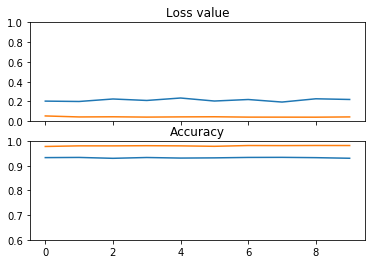

In [77]:
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0,0.20,0.40,0.60,0.80,1.00])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.6,0.7,0.8,0.9,1.0])
plt.title('Accuracy',fontsize=12)
plt.show()


In [ ]:
example = data[400] # get the tokens
print (df['article'][400])

# Print tokens as text
for w in example:
    x = inv_index.get(w)
    print(x,end = ' ')

In [ ]:
# Get prediction
pred = model.predict(example.reshape(1,100))

In [ ]:
# Output predicted category
df['category'][np.argmax(pred)]

# Hyperparameters Optimization

In [ ]:
with open('Models/decisionTree_best_model.pickle', 'wb') as output:
    pickle.dump(best_lrc, output)
    
with open('Models/decisionTree_best_model_details.pickle', 'wb') as output:
    pickle.dump(df_models_lrc, output)